In [1]:
# %load_ext autoreload
# %autoreload 2

# Set Trial Name

In [2]:
TRIAL_NAME = "60_principle_maker_material"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [3]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [4]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [5]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [6]:
import pandas as pd
import numpy as np

sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')

# maker = pd.read_csv('../../data/maker.csv')
maker = pd.read_csv('../../extract_data/maker_rename.csv')

material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')

#production_place = pd.read_csv('../../data/production_place.csv')
production_place = pd.read_csv('../../extract_data/production_place_rename.csv')

technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
test[cfg['target']] = np.nan
train = pd.read_csv('../../data/train.csv')

In [7]:
def change_hex_to_color(color_code: str):
    color_code = color_code.replace(' ','')
    R = int(color_code[1:3], 16)
    G = int(color_code[3:5], 16)
    B = int(color_code[5:7], 16)
    return [R,G,B]

In [8]:
color['rgb'] = color['hex'].apply(lambda x : change_hex_to_color(x))

In [9]:
rgb_df = pd.DataFrame(np.stack(color['rgb']),columns= ['R','G','B'])

In [10]:
color = pd.concat([color,rgb_df],axis=1)

# del_non_overlapping_list

In [11]:
del_non_overlapping_list = [
    # 'object_id',
    'art_series_id',
    'title',
    #'description',
    #'long_title',
    'principal_maker',
    'principal_or_first_maker',
    #'sub_title',
    'copyright_holder',
    #'more_title',
    'acquisition_method',
    # 'acquisition_date',
    # 'acquisition_credit_line',
    # 'dating_presenting_date',
    # 'dating_sorting_date',
    'dating_period',
    # 'dating_year_early',
    # 'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

In [12]:
def del_non_overlapping(input_df: pd.DataFrame()):
    # for material
    train_oblect_id = train['object_id'].unique().tolist()
    test_oblect_id = test['object_id'].unique().tolist()

    train_value = set(input_df[input_df['object_id'].isin(train_oblect_id)]['name'].unique().tolist())
    test_value = set(input_df[input_df['object_id'].isin(test_oblect_id)]['name'].unique().tolist())

    common_value_list = list(train_value & test_value)

    return input_df[input_df['name'].isin(common_value_list)]

material = del_non_overlapping(material)
historical_person = del_non_overlapping(historical_person)
object_collection = del_non_overlapping(object_collection)
production_place = del_non_overlapping(production_place)

# Feature Enginnering

In [13]:
def create_object_feature(input_df):        
    return input_df['likes'].copy()

create_object_feature(test).head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: likes, dtype: float64

In [14]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]

    return input_df[use_columns].copy()

create_numeric_feature(train).head(2)

,dating_period,dating_year_early,dating_year_late
0,17,1660.0,1685.0
1,19,1900.0,1930.0


In [15]:
def create_categorical_feature(input_df):
    
    out_df = pd.DataFrame()
    
    use_columns = [
    'title',
    'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    ]
    
    out_df = input_df[use_columns].copy()
    
    # out_df['principal_maker_acquisition_method'] =  input_df['principal_maker'] + '_' + input_df['acquisition_method']

    return out_df

create_categorical_feature(train).head()

,title,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method
0,other,other,Jan Hackaert,Jan Hackaert,missing,purchase
1,other,other,Richard Tepe,Richard Tepe,erven Richard Tepe,purchase
2,Portret van een vrouw,other,other,other,missing,gift
3,other,other,other,other,missing,bequest
4,other,other,anonymous,anonymous,missing,unknown


In [16]:
def create_principalmaker_agg_feature(input_df):

    out_df = pd.DataFrame()
    
    train_tmp = pd.read_csv('../../data/train.csv')
    test_tmp = pd.read_csv('../../data/test.csv')
    
    all_df = pd.concat([train_tmp,test_tmp],axis=0)
    
    all_df['title_len'] = all_df['title'].str.len()
    all_df['sub_title_len'] = all_df['sub_title'].str.len()
    all_df['long_title_len'] = all_df['long_title'].str.len()
    all_df['description_len'] = all_df['description'].str.len()
    all_df['more_title_len'] = all_df['more_title'].str.len()
    
    all_df['description'] = all_df['description'].fillna('missing')
    all_df['more_title'] = all_df['more_title'].fillna('missing')
    
    all_df['title_words_num'] = all_df['title'].apply(lambda x : len(x.split(' ')))
    all_df['sub_title_words_num'] = all_df['sub_title'].apply(lambda x : len(str(x).split(' ')))
    all_df['long_title_words_num'] = all_df['long_title'].apply(lambda x : len(x.split(' ')))
    all_df['description_words_num'] = all_df['description'].apply(lambda x : len(x.split(' ')))
    all_df['more_title_words_num'] = all_df['more_title'].apply(lambda x : len(x.split(' ')))
    
    group = all_df.groupby('principal_maker')

    agg_df = pd.concat([
        group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
        # title
        group['title'].nunique().rename('title_num'), # 著者ごとに何種類の title を持っているか
        group['title_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('title_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['title_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('title_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        # sub_title
        group['sub_title'].nunique().rename('sub_title_num'), # 著者ごとに何種類の title を持っているか
        group['sub_title_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('sub_title_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['sub_title_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('sub_title_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        # sub_title
        group['long_title'].nunique().rename('long_title_num'), # 著者ごとに何種類の title を持っているか
        group['long_title_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('long_title_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['long_title_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('long_title_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        # description
        group['description'].nunique().rename('description_num'), # 著者ごとに何種類の title を持っているか
        group['description_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('description_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['description_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('description_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        # more_title
        group['more_title'].nunique().rename('more_title_num'), # 著者ごとに何種類の title を持っているか
        group['more_title_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('more_title_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['more_title_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('more_title_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        
        group['art_series_id'].nunique().rename('art_series_id_num'), # 著者ごとに何種類の art_series_id を持っているか
        group['acquisition_method'].nunique().rename('acquisition_method_num'), # 著者ごとに何種類の acquisition_method を持っているか
        group['dating_sorting_date'].agg(['min', 'max', 'mean','std']).add_prefix('dating_sorting_date_'), # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)
    ], axis=1)
    
    # otherにはnanを入れる
    agg_df.loc['other':'principal_maker'] = np.nan
    
    out_df = pd.merge(input_df['principal_maker'], agg_df, on='principal_maker', how='left')
    
    return out_df.iloc[:,1:].add_prefix('AggregationPrincipalMaker_')

create_principalmaker_agg_feature(train).head(2)

,AggregationPrincipalMaker_size,AggregationPrincipalMaker_title_num,AggregationPrincipalMaker_title_len_min,AggregationPrincipalMaker_title_len_max,AggregationPrincipalMaker_title_len_mean,AggregationPrincipalMaker_title_len_std,AggregationPrincipalMaker_title_words_num_min,AggregationPrincipalMaker_title_words_num_max,AggregationPrincipalMaker_title_words_num_mean,AggregationPrincipalMaker_title_words_num_std,...,AggregationPrincipalMaker_more_title_words_num_min,AggregationPrincipalMaker_more_title_words_num_max,AggregationPrincipalMaker_more_title_words_num_mean,AggregationPrincipalMaker_more_title_words_num_std,AggregationPrincipalMaker_art_series_id_num,AggregationPrincipalMaker_acquisition_method_num,AggregationPrincipalMaker_dating_sorting_date_min,AggregationPrincipalMaker_dating_sorting_date_max,AggregationPrincipalMaker_dating_sorting_date_mean,AggregationPrincipalMaker_dating_sorting_date_std
0,5.0,5.0,18.0,29.0,21.800000,4.207137,2.0,4.0,3.600000,0.894427,...,2.0,4.0,3.600000,0.894427,5.0,3.0,1660.0,1660.0,1660.000000,0.000000
1,364.0,336.0,5.0,121.0,35.612637,18.008751,1.0,22.0,6.043956,3.220670,...,1.0,42.0,9.021978,6.521806,336.0,2.0,1900.0,1937.0,1900.423077,3.086827


In [17]:
def create_dating_period_agg_feature(input_df):

    out_df = pd.DataFrame()
    
    train_tmp = pd.read_csv('../../data/train.csv')
    test_tmp = pd.read_csv('../../data/test.csv')
    
    all_df = pd.concat([train_tmp,test_tmp],axis=0)
    
    all_df['title_len'] = all_df['title'].str.len()
    all_df['sub_title_len'] = all_df['sub_title'].str.len()
    all_df['long_title_len'] = all_df['long_title'].str.len()
    all_df['description_len'] = all_df['description'].str.len()
    all_df['more_title_len'] = all_df['more_title'].str.len()
    
    all_df['description'] = all_df['description'].fillna('missing')
    all_df['more_title'] = all_df['more_title'].fillna('missing')
    
    all_df['title_words_num'] = all_df['title'].apply(lambda x : len(x.split(' ')))
    all_df['sub_title_words_num'] = all_df['sub_title'].apply(lambda x : len(str(x).split(' ')))
    all_df['long_title_words_num'] = all_df['long_title'].apply(lambda x : len(x.split(' ')))
    all_df['description_words_num'] = all_df['description'].apply(lambda x : len(x.split(' ')))
    all_df['more_title_words_num'] = all_df['more_title'].apply(lambda x : len(x.split(' ')))
    
    group = all_df.groupby('dating_period')

    agg_df = pd.concat([
        group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
        # title
        group['title'].nunique().rename('title_num'), # 著者ごとに何種類の title を持っているか
        group['title_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('title_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['title_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('title_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        # sub_title
        group['sub_title'].nunique().rename('sub_title_num'), # 著者ごとに何種類の title を持っているか
        group['sub_title_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('sub_title_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['sub_title_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('sub_title_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        # sub_title
        group['long_title'].nunique().rename('long_title_num'), # 著者ごとに何種類の title を持っているか
        group['long_title_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('long_title_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['long_title_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('long_title_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        # description
        group['description'].nunique().rename('description_num'), # 著者ごとに何種類の title を持っているか
        group['description_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('description_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['description_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('description_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        # more_title
        group['more_title'].nunique().rename('more_title_num'), # 著者ごとに何種類の title を持っているか
        group['more_title_len'].agg(['min', 'max', 'mean', 'std']).add_prefix('more_title_len_'), # 著者ごとに描いた年度の最小・最大・平均
        group['more_title_words_num'].agg(['min', 'max', 'mean', 'std']).add_prefix('more_title_words_num_'), # 著者ごとに描いた年度の最小・最大・平均
        
        group['art_series_id'].nunique().rename('art_series_id_num'), # 著者ごとに何種類の art_series_id を持っているか
        group['acquisition_method'].nunique().rename('acquisition_method_num'), # 著者ごとに何種類の acquisition_method を持っているか
        
    ], axis=1)
    
    # otherにはnanを入れる
    # agg_df.loc['other':'principal_maker'] = np.nan
    
    out_df = pd.merge(input_df['dating_period'], agg_df, on='dating_period', how='left')
    
    return out_df.iloc[:,1:].add_prefix('DatingPeriod_')

create_dating_period_agg_feature(train).head(2)

,DatingPeriod_size,DatingPeriod_title_num,DatingPeriod_title_len_min,DatingPeriod_title_len_max,DatingPeriod_title_len_mean,DatingPeriod_title_len_std,DatingPeriod_title_words_num_min,DatingPeriod_title_words_num_max,DatingPeriod_title_words_num_mean,DatingPeriod_title_words_num_std,...,DatingPeriod_more_title_len_min,DatingPeriod_more_title_len_max,DatingPeriod_more_title_len_mean,DatingPeriod_more_title_len_std,DatingPeriod_more_title_words_num_min,DatingPeriod_more_title_words_num_max,DatingPeriod_more_title_words_num_mean,DatingPeriod_more_title_words_num_std,DatingPeriod_art_series_id_num,DatingPeriod_acquisition_method_num
0,6022,5036,3,231,41.011292,24.521236,1,36,6.602458,3.978565,...,4.0,787.0,77.084723,79.918142,1,136,11.884590,12.506851,5690,8
1,10135,8477,3,452,48.108929,29.014270,1,67,7.642427,4.551529,...,3.0,598.0,61.611647,43.814251,1,90,9.648545,6.816045,9471,7


In [18]:
import pycld2 as cld2

def create_lang_info(input_df):
    
    out_df = pd.DataFrame()
    
    train_tmp = pd.read_csv('../../data/train.csv')
    test_tmp = pd.read_csv('../../data/test.csv')
    
    all_df = pd.concat([train_tmp,test_tmp],axis=0)
    
    all_df["title_lang"] = all_df["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
    
    out_df = pd.merge(input_df['object_id'], all_df[['object_id','title_lang']], on='object_id', how='left')
    
    return out_df.iloc[:,1:]

create_lang_info(train).head(2)

,title_lang
0,en
1,un


In [19]:
import re

def create_maker_feature(input_df):
    merge_df = pd.merge(input_df['principal_maker'], maker, left_on='principal_maker', right_on='name',how='left')
    merge_df = merge_df.fillna('missing')

    def get_year(text: str):
        match = re.search(r'[0-9]{4}', text)
        if match:
            return match.group()
        else:
            return np.nan
        
    def get_month(text: str):
        match = re.search(r'-[0-9]{2}-', text)
        if match:
            return match.group()[1:-1]
        else:
            return np.nan
    
    # year
    merge_df['date_of_birth_year'] = merge_df['date_of_birth'].apply(lambda x : get_year(x)).astype('float')
    merge_df['date_of_death_year'] = merge_df['date_of_death'].apply(lambda x : get_year(x)).astype('float')
    
    # month
    merge_df['date_of_birth_month'] = merge_df['date_of_birth'].apply(lambda x : get_month(x)).astype('float')
    merge_df['date_of_death_month'] = merge_df['date_of_death'].apply(lambda x : get_month(x)).astype('float')
    
    del_list = [
        'name',
        'Unnamed: 0',
        'place_of_birth',
        'place_of_death',
        'principal_maker',
        'date_of_birth',
        'date_of_death'
    ]
    
    merge_df = merge_df.drop(del_list,axis=1)
    
    return merge_df

create_maker_feature(train).head(2)

,nationality,place_of_birth_country_name,place_of_death_country_name,date_of_birth_year,date_of_death_year,date_of_birth_month,date_of_death_month
0,missing,Netherlands,Netherlands,1628.0,1705.0,NaN,NaN
1,missing,Netherlands,Netherlands,1864.0,1952.0,NaN,NaN


In [22]:
def create_material_feature(input_df):
    material_list_df = material.groupby("object_id")["name"].apply(list)
    material_list_df = material_list_df.apply(lambda x : str(x))
    
    out_df = pd.DataFrame()
    
#    vc = material['name'].value_counts()

#     # 出現回数30以上に絞る
#     use_names = vc[vc >= 30].index

#     # isin で 30 回以上でてくるようなレコードに絞り込んでから crosstab を行なう
#     idx = material['name'].isin(use_names)
#     material_only_frequence = material[idx].reset_index(drop=True)

#     cross_material = pd.crosstab(material_only_frequence['object_id'], material_only_frequence['name']).reset_index()

#     input_material = pd.merge(input_df['object_id'], cross_material, on='object_id',how='left')
#     input_material.columns = [col.replace(',','') for col in input_material.columns]
    
#     out_df = pd.merge(input_df['object_id'], input_material, on='object_id', how='left')

    out_df = pd.merge(input_df['object_id'], material_list_df, on='object_id', how='left')

    material_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_w2v.csv')
    material_collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_w2v.csv')
    material_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_technique_w2v.csv')
    material_collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_w2v.csv')
    material_collection_technique_production_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_w2v.csv')
    material_collection_technique_production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_country_w2v.csv')
    material_collection_technique_role_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_role_w2v.csv')
    
    out_df = pd.merge(out_df, material_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_country_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_role_w2v, on='object_id', how='left')
    
    out_df['principle_maker_material'] = input_df['principal_maker'] + '_' + out_df['name']
    
    return out_df.iloc[:,1:].add_prefix('Material_')

create_material_feature(train).head(2)

,Material_name,Material_material_w2v_0,Material_material_w2v_1,Material_material_w2v_2,Material_material_w2v_3,Material_material_w2v_4,Material_material_w2v_5,Material_material_w2v_6,Material_material_w2v_7,Material_material_w2v_8,...,Material_material_collection_technique_role_w2v_21,Material_material_collection_technique_role_w2v_22,Material_material_collection_technique_role_w2v_23,Material_material_collection_technique_role_w2v_24,Material_material_collection_technique_role_w2v_25,Material_material_collection_technique_role_w2v_26,Material_material_collection_technique_role_w2v_27,Material_material_collection_technique_role_w2v_28,Material_material_collection_technique_role_w2v_29,Material_principle_maker_material
0,"['oil paint (paint)', 'canvas']",0.278293,-0.231511,-0.662789,0.991121,0.265224,0.322988,0.102308,-0.456635,-0.190513,...,0.502012,0.047211,-0.182898,0.978750,-0.066437,1.571582,-0.086144,-0.090589,-0.225318,"Jan Hackaert_['oil paint (paint)', 'canvas']"
1,['photographic paper'],0.588832,1.351733,-0.972135,0.362667,-0.376671,-1.124974,0.475698,0.625674,0.555431,...,1.005957,0.373621,-0.099789,0.550698,-0.172982,-0.290789,1.160390,-0.361053,-0.317537,Richard Tepe_['photographic paper']


In [23]:
def create_object_collection_feature(input_df):
    collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_w2v.csv')
    collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, collection_technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_object_collection_feature(train).head(2)

,collection_w2v_0,collection_w2v_1,collection_w2v_2,collection_technique_w2v_0,collection_technique_w2v_1,collection_technique_w2v_2,collection_technique_w2v_3,collection_technique_w2v_4,collection_technique_w2v_5,collection_technique_w2v_6,collection_technique_w2v_7,collection_technique_w2v_8,collection_technique_w2v_9
0,-0.649585,-0.883449,1.056636,-0.802673,-0.773696,2.710698,0.041548,-0.239502,-0.667183,-0.838723,-0.637467,0.571580,-0.086521
1,NaN,NaN,NaN,-0.155195,-0.252811,0.461979,0.062138,-0.218526,-0.039926,-0.068988,-0.283977,0.272564,-0.126860


In [24]:
def create_technique_feature(input_df):
    technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_technique_feature(train).head(2)

,technique_w2v_0,technique_w2v_1,technique_w2v_2,technique_w2v_3,technique_w2v_4,technique_w2v_5,technique_w2v_6,technique_w2v_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.230237,-0.075641,0.27766,-0.29013,-0.180698,0.399966,0.128924,-0.01231


In [25]:
def create_historical_person_feature(input_df):
    vc = historical_person['name'].value_counts()
    
    # 出現回数30以上に絞る
    use_names = vc[vc >= 30].index
    
    # isin で 30 回以上でてくるようなレコードに絞り込んでから crosstab を行なう
    idx = historical_person['name'].isin(use_names)
    historical_person_only_famous = historical_person[idx].reset_index(drop=True)
    #print(historical_person_only_famous)
        
    cross_historical_person = pd.crosstab(historical_person_only_famous['object_id'], historical_person_only_famous['name']).reset_index()
    
    input_historical_person = pd.merge(input_df['object_id'], cross_historical_person, on='object_id',how='left')
    input_historical_person.columns = [col.replace(',','') for col in input_historical_person.columns]
    return input_historical_person.iloc[:,1:].add_prefix('HistoricalPerson_')
  
create_historical_person_feature(train).head(2)

,HistoricalPerson_Djatiroto Suikeronderneming,HistoricalPerson_Frederik Hendrik (prins van Oranje),HistoricalPerson_Handels Vereeniging Amsterdam,HistoricalPerson_Jacobus II (koning van Engeland en Schotland),HistoricalPerson_Lodewijk XIV (koning van Frankrijk),HistoricalPerson_Maria II Stuart (koningin van Engeland Schotland en Ierland),HistoricalPerson_Maurits (prins van Oranje),HistoricalPerson_Musschenbroek Sam van,HistoricalPerson_Oldenbarnevelt Johan van,HistoricalPerson_Ruyter Michiel Adriaansz. de,...,HistoricalPerson_Wilhelm II (keizer van Duitsland),HistoricalPerson_Wilhelmina (koningin der Nederlanden),HistoricalPerson_Willem I (prins van Oranje),HistoricalPerson_Willem III (koning der Nederlanden),HistoricalPerson_Willem III (prins van Oranje en koning van Engeland Schotland en Ierland),HistoricalPerson_Willem V (prins van Oranje-Nassau),HistoricalPerson_Wirix F.J.,HistoricalPerson_Witt Cornelis de,HistoricalPerson_Witt Johan de,HistoricalPerson_Álvarez de Toledo Fernando (3e hertog van Alva)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
def create_production_place_feature(input_df):

    out_df = pd.DataFrame()

    prodcution_w2v = pd.read_csv('../../../my_pipeline/extract_data/prodcution_w2v.csv')
    production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], prodcution_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:].add_prefix('ProductionPlace_')
  
create_production_place_feature(test).head(2)

,ProductionPlace_production_w2v_0,ProductionPlace_production_w2v_1,ProductionPlace_production_w2v_2,ProductionPlace_production_w2v_3,ProductionPlace_production_w2v_4,ProductionPlace_production_w2v_5,ProductionPlace_production_w2v_6,ProductionPlace_production_w2v_7,ProductionPlace_production_w2v_8,ProductionPlace_production_w2v_9,...,ProductionPlace_production_country_w2v_10,ProductionPlace_production_country_w2v_11,ProductionPlace_production_country_w2v_12,ProductionPlace_production_country_w2v_13,ProductionPlace_production_country_w2v_14,ProductionPlace_production_country_w2v_15,ProductionPlace_production_country_w2v_16,ProductionPlace_production_country_w2v_17,ProductionPlace_production_country_w2v_18,ProductionPlace_production_country_w2v_19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
def create_principle_maker_feature(input_df):

    out_df = pd.DataFrame()

    qualification_w2v = pd.read_csv('../../../my_pipeline/extract_data/qualification_w2v.csv')
    roles_w2v = pd.read_csv('../../../my_pipeline/extract_data/roles_w2v.csv')
    name_w2v = pd.read_csv('../../../my_pipeline/extract_data/name_w2v.csv')
    qualification_roles_w2v = pd.read_csv('../../../my_pipeline/extract_data/qualification_roles_w2v.csv')
    qualification_name_w2v = pd.read_csv('../../../my_pipeline/extract_data/qualification_name_w2v.csv')
    roles_name_w2v = pd.read_csv('../../../my_pipeline/extract_data/roles_name_w2v.csv')
    qualification_roles_name_w2v = pd.read_csv('../../../my_pipeline/extract_data/qualification_roles_name_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], qualification_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, roles_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, name_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, qualification_roles_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, qualification_name_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, roles_name_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, qualification_roles_name_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:].add_prefix('PrincipleMaker_')
  
create_principle_maker_feature(test).head(2)

,PrincipleMaker_qualification_w2v_0,PrincipleMaker_qualification_w2v_1,PrincipleMaker_qualification_w2v_2,PrincipleMaker_qualification_w2v_3,PrincipleMaker_qualification_w2v_4,PrincipleMaker_roles_w2v_0,PrincipleMaker_roles_w2v_1,PrincipleMaker_roles_w2v_2,PrincipleMaker_roles_w2v_3,PrincipleMaker_name_w2v_0,...,PrincipleMaker_qualification_roles_name_w2v_20,PrincipleMaker_qualification_roles_name_w2v_21,PrincipleMaker_qualification_roles_name_w2v_22,PrincipleMaker_qualification_roles_name_w2v_23,PrincipleMaker_qualification_roles_name_w2v_24,PrincipleMaker_qualification_roles_name_w2v_25,PrincipleMaker_qualification_roles_name_w2v_26,PrincipleMaker_qualification_roles_name_w2v_27,PrincipleMaker_qualification_roles_name_w2v_28,PrincipleMaker_qualification_roles_name_w2v_29
0,-1.407384,-0.298591,-0.139830,-2.478325,-2.549996,0.014012,-1.426175,-0.515558,-0.309854,-0.957639,...,-0.111333,0.104669,-0.574753,0.149971,-0.063613,0.443261,-0.487553,-0.454911,-0.420477,0.023687
1,-2.742899,0.964579,-3.054511,-0.525887,-0.858646,1.628303,1.329121,1.599065,-2.243798,-0.605292,...,0.562323,-0.676779,0.284721,-0.028127,-0.183849,-0.461864,1.164964,0.868721,-0.258929,0.071831


In [28]:
import datetime

def create_acquisition_feature(input_df):
    out_df = pd.DataFrame()
    
    use_columns = [
        'acquisition_date'
    ]
    
    out_df['year'] = pd.to_datetime(input_df['acquisition_date']).dt.year
    out_df['month'] = pd.to_datetime(input_df['acquisition_date']).dt.month
    out_df['dayofweek'] = pd.to_datetime(input_df['acquisition_date']).dt.dayofweek
    out_df['sum_time'] =  10**10 - pd.to_datetime(input_df['acquisition_date']).view('int') // 10**9
    
    return out_df.add_prefix('AcquisitionDate_')

create_acquisition_feature(train).head(2)

,AcquisitionDate_year,AcquisitionDate_month,AcquisitionDate_dayofweek,AcquisitionDate_sum_time
0,1808.0,1.0,4.0,15112288000
1,2000.0,1.0,5.0,9053315200


In [29]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()
    
    train_tmp = pd.read_csv('../../data/train.csv')
    test_tmp = pd.read_csv('../../data/test.csv')
    
    all_df = pd.concat([train_tmp,test_tmp],axis=0)

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title',
        'description',
    ]
    
    all_df[str_columns] = all_df[str_columns].fillna('missing')

    use_col = []
    
    for c in str_columns:
        all_df[f'len_{c}'] = all_df[c].str.len()
        use_col.append(f'len_{c}')
        
    for c in str_columns:
        all_df[f'word_num_{c}'] = all_df[c].apply(lambda x : len(x.split(' ')))
        use_col.append(f'word_num_{c}')

    use_col.append('object_id')
        
    out_df = pd.merge(input_df['object_id'], all_df[use_col], on='object_id', how='left')
        
    return out_df.iloc[:,1:].add_prefix('StringLength__')

create_string_length_feature(train).head(2)

,StringLength__len_title,StringLength__len_long_title,StringLength__len_sub_title,StringLength__len_more_title,StringLength__len_description,StringLength__word_num_title,StringLength__word_num_long_title,StringLength__word_num_sub_title,StringLength__word_num_more_title,StringLength__word_num_description
0,21,48,39,21,7,4,9,11,4,1
1,15,64,17,15,7,3,12,5,3,1


In [30]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'acquisition_date',
        'acquisition_credit_line',
        #'art_series_id', 
        'principal_maker',
        'principal_or_first_maker',
        'description', 
        'dating_presenting_date',
        'dating_sorting_date',
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'title',
        'long_title',
        'sub_title',
        'copyright_holder',
        'more_title',
    ]

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

create_count_encoding_feature(train).head(2)

,CE_acquisition_method,CE_acquisition_date,CE_acquisition_credit_line,CE_principal_maker,CE_principal_or_first_maker,CE_description,CE_dating_presenting_date,CE_dating_sorting_date,CE_dating_period,CE_dating_year_early,CE_dating_year_late,CE_title,CE_long_title,CE_sub_title,CE_copyright_holder,CE_more_title
0,4253,48.0,NaN,3,3,NaN,3.0,65.0,3005,65.0,30.0,10516,1,1.0,11313,1.0
1,4253,231.0,NaN,180,180,NaN,77.0,321.0,5042,321.0,214.0,10516,1,1.0,180,1.0


In [31]:
# def create_one_hot_encoding(input_df):
#     use_columns = [
#         'acquisition_method',
#         'principal_maker'
#     ]
#     out_df = pd.DataFrame()
#     for column in use_columns:

#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = train[column].value_counts()
#         vc = vc[vc > 20]

#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(input_df[column], categories=vc.index)

#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

# create_one_hot_encoding(train).head(2)

In [32]:
import re

#  h 166mm × w 78/54mm

def get_h_from_subtitle(text:str):
    match_cm = re.search(r'h \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'h \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100

def get_w_from_subtitle(text:str):
    match_cm = re.search(r'w \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'w \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        elif match_mm.group()[2:-2] == '78/54':
            return float(78)
        else:
            return float(match_mm.group()[2:-2])/100    

def get_t_from_subtitle(text:str):
    match_cm = re.search(r't \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r't \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   

def get_d_from_subtitle(text:str):
    match_cm = re.search(r'd \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'd \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   
        
def create_subtitle_info(input_df):
    out_df = pd.DataFrame()
     
    out_df['subtitle_h'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_h_from_subtitle(x))
    out_df['subtitle_w'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_w_from_subtitle(x))
    out_df['subtitle_t'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_t_from_subtitle(x))
    out_df['subtitle_d'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_d_from_subtitle(x))
    
    out_df['area'] = out_df['subtitle_h'] * out_df['subtitle_w']
    out_df['volume'] = out_df['subtitle_h'] * out_df['subtitle_w'] * out_df['subtitle_t']

    return out_df

create_subtitle_info(test).head(2)

,subtitle_h,subtitle_w,subtitle_t,subtitle_d,area,volume
0,1.67,1.08,NaN,NaN,1.8036,NaN
1,29.70,24.10,NaN,NaN,715.7700,NaN


In [33]:
from util import use_pca

def create_description_emb(input_df):
    
    pca_num = 100#256
    
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_description_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], pca_num)# 256
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(pca_num)]].add_prefix('DescriptionEmb_')

create_description_emb(test).tail(2)

,DescriptionEmb_pca_0,DescriptionEmb_pca_1,DescriptionEmb_pca_2,DescriptionEmb_pca_3,DescriptionEmb_pca_4,DescriptionEmb_pca_5,DescriptionEmb_pca_6,DescriptionEmb_pca_7,DescriptionEmb_pca_8,DescriptionEmb_pca_9,...,DescriptionEmb_pca_90,DescriptionEmb_pca_91,DescriptionEmb_pca_92,DescriptionEmb_pca_93,DescriptionEmb_pca_94,DescriptionEmb_pca_95,DescriptionEmb_pca_96,DescriptionEmb_pca_97,DescriptionEmb_pca_98,DescriptionEmb_pca_99
12006,4.868664,-2.158484,0.022857,0.005380,-0.005051,-0.033197,-0.030381,0.001403,-0.000757,-0.003157,...,0.000159,0.000205,-0.000323,-0.000436,0.000310,-0.000575,0.000126,-0.000125,-0.000507,-0.000015
12007,-2.857194,-0.279421,-1.757069,-0.255254,-0.783501,-0.267247,-0.262805,-0.261660,0.870815,-0.289137,...,0.110985,-0.056765,-0.017974,0.048606,-0.031877,-0.004177,0.017785,0.017690,0.047591,0.071728


In [34]:
from util import use_pca

def create_longtitle_emb(input_df):
    
    pca_num = 100#256
    
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_longtitle_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], pca_num) #256
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(pca_num)]].add_prefix('LongTitleEmb_')

create_longtitle_emb(train).tail(2)

,LongTitleEmb_pca_0,LongTitleEmb_pca_1,LongTitleEmb_pca_2,LongTitleEmb_pca_3,LongTitleEmb_pca_4,LongTitleEmb_pca_5,LongTitleEmb_pca_6,LongTitleEmb_pca_7,LongTitleEmb_pca_8,LongTitleEmb_pca_9,...,LongTitleEmb_pca_90,LongTitleEmb_pca_91,LongTitleEmb_pca_92,LongTitleEmb_pca_93,LongTitleEmb_pca_94,LongTitleEmb_pca_95,LongTitleEmb_pca_96,LongTitleEmb_pca_97,LongTitleEmb_pca_98,LongTitleEmb_pca_99
12024,0.134985,0.274561,-0.355268,-0.568042,0.490875,-0.759768,0.800044,0.492070,-0.684621,-0.055642,...,0.117449,-0.059403,0.128136,0.194857,-0.125398,0.058031,0.040140,0.008955,-0.061796,-0.10355
12025,3.315138,0.391919,-0.387956,-0.729403,-0.963979,-1.700643,-0.560264,0.077446,0.027742,-0.265691,...,-0.003193,0.215697,0.086505,-0.029067,0.137139,-0.245680,0.210944,-0.213907,0.020805,-0.12539


In [35]:
# train_emb_df = pd.read_csv('../../extract_data/train_all_more_title_emb.csv').iloc[:,1:]
# test_emb_df = pd.read_csv('../../extract_data/test_all_more_title_emb.csv').iloc[:,1:]
# all_emb_df = pd.concat([train_emb_df, test_emb_df],axis=0).reset_index(drop=True)
# all_emb_df.to_pickle('../../extract_data/all_more_title_emb.pkl')

In [36]:
from util import use_pca

def create_moretitle_emb(input_df):
    
    pca_num = 100#256
    
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_more_title_emb.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], pca_num)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(pca_num)]].add_prefix('MoreTitleEmb_')

create_moretitle_emb(train).tail(2)

,MoreTitleEmb_pca_0,MoreTitleEmb_pca_1,MoreTitleEmb_pca_2,MoreTitleEmb_pca_3,MoreTitleEmb_pca_4,MoreTitleEmb_pca_5,MoreTitleEmb_pca_6,MoreTitleEmb_pca_7,MoreTitleEmb_pca_8,MoreTitleEmb_pca_9,...,MoreTitleEmb_pca_90,MoreTitleEmb_pca_91,MoreTitleEmb_pca_92,MoreTitleEmb_pca_93,MoreTitleEmb_pca_94,MoreTitleEmb_pca_95,MoreTitleEmb_pca_96,MoreTitleEmb_pca_97,MoreTitleEmb_pca_98,MoreTitleEmb_pca_99
12024,-1.621602,0.495788,0.815646,-0.214586,0.590383,0.147128,-0.756365,-0.784875,-0.389968,0.249817,...,0.048131,0.14972,-0.215531,-0.127895,-0.238133,0.210186,-0.090499,0.335198,0.139074,0.209258
12025,5.888203,-2.353538,-0.045900,-1.240266,0.274434,-1.162377,-0.212998,-1.767908,0.654546,0.568968,...,0.114427,-0.19089,0.221309,0.062964,-0.365680,-0.495108,0.302146,-0.040194,-0.196811,-0.212448


In [37]:
def create_palette_feature(input_df):
    output_df = input_df.copy()

    # ratio最大のものを取得
    max_palette = palette.groupby('object_id')['ratio'].max().reset_index()
    max_palette = pd.merge(max_palette, palette, on=['object_id','ratio'], how='left').rename(
        columns={"ratio":"max_ratio", "color_r":"max_palette_r", "color_g":"max_palette_g","color_b":"max_palette_b"})  
    max_palette = max_palette.loc[max_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df['object_id'], max_palette, on="object_id", how="left")

    # 平均のrgbを取得
    mean_palette = palette.copy()
    mean_palette["color_r"] = palette["ratio"] * palette["color_r"]
    mean_palette["color_g"] = palette["ratio"] * palette["color_g"]
    mean_palette["color_b"] = palette["ratio"] * palette["color_b"]
    mean_palette = mean_palette.groupby("object_id").sum().reset_index().rename(
        columns={"color_r":"mean_palette_r", "color_g":"mean_palette_g","color_b":"mean_palette_b"})
    output_df = pd.merge(output_df, mean_palette, on="object_id", how="left")
    
    # rgbの標準偏差を取得
    var_palette = palette.groupby('object_id')[['color_r','color_g','color_b']].std().reset_index().reset_index().rename(
        columns={"color_r":"var_palette_r", "color_g":"var_palette_g","color_b":"var_palette_b"})
    output_df = pd.merge(output_df, var_palette, on="object_id", how="left")
    
    del_list = [
        'index_x',
        'index_y',
        'ratio'
    ]
    
    output_df = output_df.drop(del_list,axis=1)

    return output_df.iloc[:,1:].add_prefix('Palette_')

create_palette_feature(train).head(2)

,Palette_max_ratio,Palette_max_palette_r,Palette_max_palette_g,Palette_max_palette_b,Palette_mean_palette_r,Palette_mean_palette_g,Palette_mean_palette_b,Palette_var_palette_r,Palette_var_palette_g,Palette_var_palette_b
0,0.108754,54.0,30.0,5.0,80.760794,52.411413,10.170802,41.500978,34.432694,16.243813
1,0.095855,70.0,51.0,42.0,93.112586,68.715265,56.557897,30.799625,27.169661,21.839636


In [38]:
def create_color_feature(input_df):
    output_df = input_df.copy()

    # ratio最大のものを取得
    max_color = color.groupby('object_id')['percentage'].max().reset_index()
    max_color = pd.merge(max_color, color, on=['object_id','percentage'], how='left').rename(
        columns={"percentage":"max_percentage", "R":"max_color_R", "G":"max_color_G","B":"max_color_B"})  
    max_color = max_color.loc[max_color["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df['object_id'], max_color, on="object_id", how="left")
    output_df = output_df[['object_id','max_percentage','max_color_R','max_color_G','max_color_B']]

    # 平均のrgbを取得
    mean_color = color.copy()
    mean_color["color_R"] = color["percentage"] / 100 * color["R"]
    mean_color["color_G"] = color["percentage"] / 100 * color["G"]
    mean_color["color_B"] = color["percentage"] / 100 * color["B"]
    mean_color = mean_color.groupby("object_id").sum().reset_index().rename(
        columns={"color_R":"mean_color_R", "color_G":"mean_color_G","color_B":"mean_color_B"})
    output_df = pd.merge(output_df, mean_color, on="object_id", how="left")
    
    # rgbの標準偏差を取得
    var_color = color.groupby('object_id')[['R','G','B']].std().reset_index().reset_index().rename(
        columns={"R":"var_color_R", "G":"var_color_G","B":"var_color_B"})
    output_df = pd.merge(output_df, var_color, on="object_id", how="left")

    del_list = [
        'percentage',
        'index'
    ]
    
    output_df = output_df.drop(del_list,axis=1)
    
    return output_df.iloc[:,1:].add_prefix('Color_')

create_color_feature(train).head(2)

,Color_max_percentage,Color_max_color_R,Color_max_color_G,Color_max_color_B,Color_R,Color_G,Color_B,Color_mean_color_R,Color_mean_color_G,Color_mean_color_B,Color_var_color_R,Color_var_color_G,Color_var_color_B
0,58.0,62.0,57.0,45.0,801.0,708.0,514.0,75.96,66.99,48.83,52.620836,50.768851,42.16182
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# from util import use_pca

# def create_image_feature(input_df):
#     out_df = pd.DataFrame()
    
#     all_image_feature = pd.read_pickle('../../extract_data/all_image_feature.pkl').reset_index(drop='True')

#     all_image_feature_256 = use_pca(all_image_feature.iloc[:,1:], 256)
#     all_emb_df_256 = pd.concat([all_image_feature['object_id'], all_image_feature_256], axis=1)
    
#     input_image_feature = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
#     return input_image_feature.iloc[:,1:].add_prefix('ImageFeature_')

# create_image_feature(test).head()

In [40]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [41]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_object_feature,
        create_numeric_feature,
        create_categorical_feature,
        create_principalmaker_agg_feature,
        create_dating_period_agg_feature,
        create_lang_info,
        create_maker_feature,
        create_historical_person_feature,
        create_material_feature,
        create_object_collection_feature,
        create_technique_feature,
        create_production_place_feature,
        create_principle_maker_feature,
        create_acquisition_feature,
        create_palette_feature,
        create_color_feature,
        ### create_principal_maker_info_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        #create_one_hot_encoding,
        create_subtitle_info,
        create_description_emb,
        create_longtitle_emb,
        create_moretitle_emb
        #create_image_feature
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

train_feat= to_feature(train)
test_feat = to_feature(test)

train = train_feat.copy()
test = test_feat.copy()

  0%|          | 0/22 [00:00<?, ?it/s]

createcreate_object_feature  0.001[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]


 18%|█▊        | 4/22 [00:00<00:02,  8.67it/s]

createcreate_principalmaker_agg_feature  0.443[s]


 23%|██▎       | 5/22 [00:00<00:03,  4.95it/s]

createcreate_dating_period_agg_feature  0.391[s]


 36%|███▋      | 8/22 [00:01<00:02,  5.30it/s]

createcreate_lang_info  0.315[s]
createcreate_maker_feature  0.062[s]
createcreate_historical_person_feature  0.031[s]


 45%|████▌     | 10/22 [00:03<00:07,  1.70it/s]

createcreate_material_feature  2.146[s]
createcreate_object_collection_feature  0.065[s]
createcreate_technique_feature  0.034[s]


 55%|█████▍    | 12/22 [00:03<00:04,  2.20it/s]

createcreate_production_place_feature  0.120[s]


 64%|██████▎   | 14/22 [00:04<00:02,  2.67it/s]

createcreate_principle_maker_feature  0.469[s]
createcreate_acquisition_feature  0.017[s]


 68%|██████▊   | 15/22 [00:05<00:03,  2.29it/s]

createcreate_palette_feature  0.492[s]


 73%|███████▎  | 16/22 [00:05<00:02,  2.69it/s]

createcreate_color_feature  0.122[s]


 77%|███████▋  | 17/22 [00:05<00:02,  2.49it/s]

createcreate_string_length_feature  0.372[s]
createcreate_count_encoding_feature  0.058[s]


 86%|████████▋ | 19/22 [00:06<00:00,  3.46it/s]

createcreate_subtitle_info  0.091[s]


 91%|█████████ | 20/22 [00:07<00:00,  2.20it/s]

createcreate_description_emb  0.750[s]


 95%|█████████▌| 21/22 [00:07<00:00,  1.77it/s]

createcreate_longtitle_emb  0.732[s]


  0%|          | 0/22 [00:00<?, ?it/s]

createcreate_moretitle_emb  1.428[s]
createcreate_object_feature  0.000[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]


 18%|█▊        | 4/22 [00:00<00:02,  8.96it/s]

createcreate_principalmaker_agg_feature  0.429[s]


 23%|██▎       | 5/22 [00:00<00:03,  4.91it/s]

createcreate_dating_period_agg_feature  0.404[s]


 36%|███▋      | 8/22 [00:01<00:02,  5.23it/s]

createcreate_lang_info  0.318[s]
createcreate_maker_feature  0.065[s]
createcreate_historical_person_feature  0.033[s]


 45%|████▌     | 10/22 [00:03<00:07,  1.69it/s]

createcreate_material_feature  2.157[s]
createcreate_object_collection_feature  0.063[s]
createcreate_technique_feature  0.032[s]


 55%|█████▍    | 12/22 [00:03<00:04,  2.20it/s]

createcreate_production_place_feature  0.115[s]


 64%|██████▎   | 14/22 [00:04<00:02,  2.74it/s]

createcreate_principle_maker_feature  0.460[s]
createcreate_acquisition_feature  0.014[s]


 68%|██████▊   | 15/22 [00:05<00:02,  2.36it/s]

createcreate_palette_feature  0.470[s]
createcreate_color_feature  0.109[s]


 77%|███████▋  | 17/22 [00:05<00:01,  2.61it/s]

createcreate_string_length_feature  0.348[s]
createcreate_count_encoding_feature  0.063[s]


 86%|████████▋ | 19/22 [00:06<00:00,  3.58it/s]

createcreate_subtitle_info  0.089[s]


 91%|█████████ | 20/22 [00:07<00:00,  2.15it/s]

createcreate_description_emb  0.802[s]


 95%|█████████▌| 21/22 [00:07<00:00,  1.68it/s]

createcreate_longtitle_emb  0.800[s]


100%|██████████| 22/22 [00:09<00:00,  2.29it/s]

createcreate_moretitle_emb  1.561[s]


In [42]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [43]:
# train.to_csv('../EDA/train_for_EDA.csv')
# test.to_csv('../EDA/test_for_EDA.csv')

In [44]:
# train = train.fillna(-999)
# test = test.fillna(-999)

# train

In [45]:
# from collections import Counter
# Counter(train.columns.tolist())

In [46]:
train.head(2)

,likes,dating_period,dating_year_early,dating_year_late,title,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,...,MoreTitleEmb_pca_90,MoreTitleEmb_pca_91,MoreTitleEmb_pca_92,MoreTitleEmb_pca_93,MoreTitleEmb_pca_94,MoreTitleEmb_pca_95,MoreTitleEmb_pca_96,MoreTitleEmb_pca_97,MoreTitleEmb_pca_98,MoreTitleEmb_pca_99
0,48,17,1660.0,1685.0,other,other,Jan Hackaert,Jan Hackaert,missing,purchase,...,0.069602,0.123016,0.403856,0.770215,-0.459711,0.068330,-0.391813,0.033751,-0.349632,-0.289582
1,2,19,1900.0,1930.0,other,other,Richard Tepe,Richard Tepe,erven Richard Tepe,purchase,...,0.092891,0.061481,-0.101694,0.189995,-0.218909,0.135019,0.159518,0.313387,-0.032913,-0.156040


In [47]:
test.head(2)

,likes,dating_period,dating_year_early,dating_year_late,title,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,...,MoreTitleEmb_pca_90,MoreTitleEmb_pca_91,MoreTitleEmb_pca_92,MoreTitleEmb_pca_93,MoreTitleEmb_pca_94,MoreTitleEmb_pca_95,MoreTitleEmb_pca_96,MoreTitleEmb_pca_97,MoreTitleEmb_pca_98,MoreTitleEmb_pca_99
0,NaN,19,1850.0,1900.0,other,other,Bernardus Bruining,Bernardus Bruining,missing,transfer,...,-0.307178,-0.122312,0.008525,-0.156739,-0.240617,0.094477,0.092902,0.004983,-0.157628,0.049624
1,NaN,17,1609.0,1633.0,other,other,Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,missing,nationalization 1795,...,0.055793,-0.105094,-0.018468,0.250062,-0.053521,0.067508,0.343878,0.626805,-0.004256,-0.073041


# reduce mem usage

In [48]:
from util import reduce_mem_usage
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 20.08 Mb (70.5% reduction)
Mem. usage decreased to 20.13 Mb (70.4% reduction)


# del_non_overlapping 2

In [50]:
col_list = [
    'title_lang',
    #'principal_maker_acquisition_method',
    'Material_name',
    'Material_principle_maker_material'
]

train, test = replace_non_overlap_val_to_missing(train,test,columns=col_list)

# Lable Encoding

In [51]:
cat_col = train.select_dtypes('O').columns.tolist()

In [52]:
cat_col#.remove('Material_name')

['title',
 'art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name',
 'Material_name',
 'Material_principle_maker_material']

In [53]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [55]:
train.dtypes

likes                    int16
dating_period             int8
dating_year_early      float16
dating_year_late       float16
title                    int64
                        ...   
MoreTitleEmb_pca_95    float16
MoreTitleEmb_pca_96    float16
MoreTitleEmb_pca_97    float16
MoreTitleEmb_pca_98    float16
MoreTitleEmb_pca_99    float16
Length: 843, dtype: object

# add fold

In [56]:
from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Target Encoding

In [57]:
target_enc_list = [
    # 'title',
    # 'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    'dating_period',
    'title_lang',
    #'principal_maker_acquisition_method'
    'Material_name',
    'Material_principle_maker_material'
]

from fe import target_encoding
train, test = target_encoding(train, 
                              test, 
                              target = cfg['target'], 
                              target_enc_list = target_enc_list, 
                              fold_num = cfg['fold_num']
                             )

principal_maker
principal_or_first_maker
copyright_holder
acquisition_method
dating_period
title_lang
Material_name
Material_principle_maker_material


# Make Model

In [58]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [59]:
use_col

['dating_period',
 'dating_year_early',
 'dating_year_late',
 'title',
 'art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'AggregationPrincipalMaker_size',
 'AggregationPrincipalMaker_title_num',
 'AggregationPrincipalMaker_title_len_min',
 'AggregationPrincipalMaker_title_len_max',
 'AggregationPrincipalMaker_title_len_mean',
 'AggregationPrincipalMaker_title_len_std',
 'AggregationPrincipalMaker_title_words_num_min',
 'AggregationPrincipalMaker_title_words_num_max',
 'AggregationPrincipalMaker_title_words_num_mean',
 'AggregationPrincipalMaker_title_words_num_std',
 'AggregationPrincipalMaker_sub_title_num',
 'AggregationPrincipalMaker_sub_title_len_min',
 'AggregationPrincipalMaker_sub_title_len_max',
 'AggregationPrincipalMaker_sub_title_len_mean',
 'AggregationPrincipalMaker_sub_title_len_std',
 'AggregationPrincipalMaker_sub_title_words_num_min',
 'AggregationPrincipalMaker_sub_title_words_num_max',
 'AggregationPrincip

In [60]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [61]:
# # add weight
# from sklearn import preprocessing
# train['weight'] = preprocessing.minmax_scale(train['likes']) + 1

In [62]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False,
  use_weight=False,
  is_target_log=True)

feature_importance_df, order = lgbm.feature_importance(PLOT=False)

--------------FOLDS : 0 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Material_name', 'Material_principle_maker_material', 'acquisition_method', 'art_series_id', 'copyright_holder', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title', 'title_lang']
  warnings.warn('categorical_feature in Dat

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.16718	valid_1's rmse: 1.19846
[200]	training's rmse: 0.998681	valid_1's rmse: 1.07314
[300]	training's rmse: 0.927116	valid_1's rmse: 1.04157
[400]	training's rmse: 0.877859	valid_1's rmse: 1.02684
[500]	training's rmse: 0.837015	valid_1's rmse: 1.01742
[600]	training's rmse: 0.80182	valid_1's rmse: 1.01066
[700]	training's rmse: 0.770566	valid_1's rmse: 1.00566
[800]	training's rmse: 0.742037	valid_1's rmse: 1.00222
[900]	training's rmse: 0.716001	valid_1's rmse: 0.998681
[1000]	training's rmse: 0.691837	valid_1's rmse: 0.996418
[1100]	training's rmse: 0.669167	valid_1's rmse: 0.99392
[1200]	training's rmse: 0.64814	valid_1's rmse: 0.991349
[1300]	training's rmse: 0.628487	valid_1's rmse: 0.989519
[1400]	training's rmse: 0.609461	valid_1's rmse: 0.988293
[1500]	training's rmse: 0.59175	valid_1's rmse: 0.986863
[1600]	training's rmse: 0.574922	valid_1's rmse: 0.985305
[1700]	training's rmse: 0.558963

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Material_name', 'Material_principle_maker_material', 'acquisition_method', 'art_series_id', 'copyright_holder', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title', 'title_lang']
  warnings.warn('categorical_feature in Dat

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.16177	valid_1's rmse: 1.20971
[200]	training's rmse: 0.992908	valid_1's rmse: 1.09157
[300]	training's rmse: 0.921407	valid_1's rmse: 1.06331
[400]	training's rmse: 0.872903	valid_1's rmse: 1.05185
[500]	training's rmse: 0.832308	valid_1's rmse: 1.04474
[600]	training's rmse: 0.797185	valid_1's rmse: 1.0396
[700]	training's rmse: 0.765778	valid_1's rmse: 1.03527
[800]	training's rmse: 0.737429	valid_1's rmse: 1.03179
[900]	training's rmse: 0.710786	valid_1's rmse: 1.02913
[1000]	training's rmse: 0.686692	valid_1's rmse: 1.02655
[1100]	training's rmse: 0.664155	valid_1's rmse: 1.02418
[1200]	training's rmse: 0.643078	valid_1's rmse: 1.02263
[1300]	training's rmse: 0.623243	valid_1's rmse: 1.02114
[1400]	training's rmse: 0.604347	valid_1's rmse: 1.01964
[1500]	training's rmse: 0.586536	valid_1's rmse: 1.01875
[1600]	training's rmse: 0.569746	valid_1's rmse: 1.01766
[1700]	training's rmse: 0.553665	vali

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Material_name', 'Material_principle_maker_material', 'acquisition_method', 'art_series_id', 'copyright_holder', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title', 'title_lang']
  warnings.warn('categorical_feature in Dat

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.16736	valid_1's rmse: 1.19587
[200]	training's rmse: 1.00096	valid_1's rmse: 1.07234
[300]	training's rmse: 0.93055	valid_1's rmse: 1.03878
[400]	training's rmse: 0.881226	valid_1's rmse: 1.02343
[500]	training's rmse: 0.840997	valid_1's rmse: 1.01369
[600]	training's rmse: 0.805512	valid_1's rmse: 1.00633
[700]	training's rmse: 0.773718	valid_1's rmse: 1.0009
[800]	training's rmse: 0.745167	valid_1's rmse: 0.997008
[900]	training's rmse: 0.718338	valid_1's rmse: 0.993705
[1000]	training's rmse: 0.694076	valid_1's rmse: 0.990713
[1100]	training's rmse: 0.671206	valid_1's rmse: 0.988391
[1200]	training's rmse: 0.649638	valid_1's rmse: 0.986313
[1300]	training's rmse: 0.62943	valid_1's rmse: 0.984413
[1400]	training's rmse: 0.610593	valid_1's rmse: 0.982688
[1500]	training's rmse: 0.5927	valid_1's rmse: 0.981473
[1600]	training's rmse: 0.575652	valid_1's rmse: 0.980341
[1700]	training's rmse: 0.559368	

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Material_name', 'Material_principle_maker_material', 'acquisition_method', 'art_series_id', 'copyright_holder', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title', 'title_lang']
  warnings.warn('categorical_feature in Dat

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.16222	valid_1's rmse: 1.21523
[200]	training's rmse: 0.993837	valid_1's rmse: 1.09763
[300]	training's rmse: 0.922581	valid_1's rmse: 1.06594
[400]	training's rmse: 0.873539	valid_1's rmse: 1.052
[500]	training's rmse: 0.832658	valid_1's rmse: 1.04359
[600]	training's rmse: 0.797329	valid_1's rmse: 1.03653
[700]	training's rmse: 0.765487	valid_1's rmse: 1.03113
[800]	training's rmse: 0.736748	valid_1's rmse: 1.0263
[900]	training's rmse: 0.710551	valid_1's rmse: 1.02287
[1000]	training's rmse: 0.686172	valid_1's rmse: 1.02092
[1100]	training's rmse: 0.663511	valid_1's rmse: 1.01897
[1200]	training's rmse: 0.642168	valid_1's rmse: 1.01737
[1300]	training's rmse: 0.622668	valid_1's rmse: 1.01583
[1400]	training's rmse: 0.603662	valid_1's rmse: 1.01414
[1500]	training's rmse: 0.585934	valid_1's rmse: 1.01291
[1600]	training's rmse: 0.569092	valid_1's rmse: 1.01226
[1700]	training's rmse: 0.552861	valid_

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Material_name', 'Material_principle_maker_material', 'acquisition_method', 'art_series_id', 'copyright_holder', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title', 'title_lang']
  warnings.warn('categorical_feature in Dat

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.16559	valid_1's rmse: 1.2143
[200]	training's rmse: 0.997418	valid_1's rmse: 1.08743
[300]	training's rmse: 0.926045	valid_1's rmse: 1.05475
[400]	training's rmse: 0.87693	valid_1's rmse: 1.03982
[500]	training's rmse: 0.836037	valid_1's rmse: 1.03031
[600]	training's rmse: 0.800637	valid_1's rmse: 1.02367
[700]	training's rmse: 0.769038	valid_1's rmse: 1.01829
[800]	training's rmse: 0.740528	valid_1's rmse: 1.01458
[900]	training's rmse: 0.714051	valid_1's rmse: 1.01111
[1000]	training's rmse: 0.689721	valid_1's rmse: 1.00861
[1100]	training's rmse: 0.667367	valid_1's rmse: 1.00575
[1200]	training's rmse: 0.646213	valid_1's rmse: 1.00336
[1300]	training's rmse: 0.626557	valid_1's rmse: 1.00143
[1400]	training's rmse: 0.607862	valid_1's rmse: 1.00003
[1500]	training's rmse: 0.590141	valid_1's rmse: 0.999217
[1600]	training's rmse: 0.57304	valid_1's rmse: 0.998238
[1700]	training's rmse: 0.556991	vali

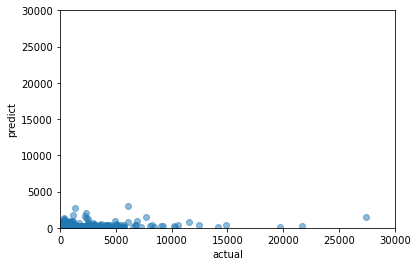

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(train['likes'],lgbm.oof,alpha=0.5);
plt.xlim(0,30000);
plt.ylim(0,30000);
plt.xlabel('actual');
plt.ylabel('predict');

In [64]:
os.makedirs(f"{OUTPUT_DIR}/imp", exist_ok=True)
feature_importance_df[order[:50]].to_csv(f"{OUTPUT_DIR}/imp/importance.csv")
display(feature_importance_df[order[:50]])

,Material_material_collection_technique_w2v_19,Material_material_collection_technique_w2v_3,Material_material_collection_w2v_19,Material_principle_maker_material_target_enc,Material_principle_maker_material,collection_technique_w2v_2,subtitle_h,Material_material_collection_technique_role_w2v_6,principal_maker,principal_or_first_maker,...,LongTitleEmb_pca_1,Color_mean_color_R,Color_max_percentage,Palette_max_palette_r,DatingPeriod_title_len_max,MoreTitleEmb_pca_2,LongTitleEmb_pca_53,Palette_var_palette_r,MoreTitleEmb_pca_23,MoreTitleEmb_pca_32
fold_0,187449.943486,157202.682483,51339.879607,28590.183766,27402.626268,31101.157851,12416.560634,2724.438631,22171.608909,13374.769502,...,2717.944297,1831.927387,2206.057140,1879.824349,5064.758628,2730.904561,2657.068964,2755.102005,2455.024591,1762.524627
fold_1,129897.979003,241876.459862,48319.318936,28980.430856,24887.908527,8585.372276,12534.512480,3989.639058,18813.238430,18247.267978,...,3676.597461,2089.185288,2707.331322,928.910001,4387.494081,3190.409424,2279.923267,1766.991462,1925.485812,1993.551881
fold_2,74306.911766,172795.165437,15727.314744,25389.222624,25291.956011,78822.972189,15462.281192,20757.769199,15684.160192,20119.815406,...,2959.701244,2107.855121,2091.652857,1554.730575,2958.724735,2772.397369,2716.162188,2306.814498,1679.764378,1969.449326
fold_3,131872.727254,138345.161443,49325.154079,24948.910989,23201.636390,70412.690762,13088.555311,20832.673533,20711.576460,18778.087667,...,3695.944230,1871.954781,1715.961841,1562.425792,3110.570232,2833.967664,2331.280502,2066.091848,2142.557748,1492.230273
fold_4,257514.978781,76307.422419,63469.719698,30648.676571,25002.168139,23375.529320,22880.254299,19198.142165,19181.436750,16951.275651,...,2669.386842,2637.087611,2623.861508,2623.224592,2620.983418,2593.846823,2587.088063,2577.029124,2468.890405,2277.860147


In [65]:
from make_data import make_oof
oof_df = make_oof(model_oof=lgbm.oof, OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [66]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [67]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [68]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210312021930_60_principle_maker_material/pred/pred_likes_0.9929.csv


In [69]:
sub_df.describe()

,likes
count,12008.000000
mean,22.892327
std,79.867282
min,0.000000
25%,1.027722
50%,2.711669
75%,7.049713
max,3520.309136


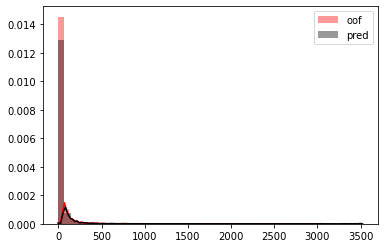

In [70]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)